In [ ]:
'''   
NS: Super Resolution

'''
import os
import sys
sys.path.append("/home/user/Documents/GPO/general")
import gpytorch
from gpytorch.means import MultitaskMean
from gpytorch.kernels import InducingPointKernel, ScaleKernel
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.distributions import MultitaskMultivariateNormal
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from utilities3 import *
from pytorch_wavelets import DWT, IDWT
from pytorch_wavelets import DWT1D, IDWT1D
import scipy
# from utils import *
# from _sdd_copy import *
from _sdd import *
from _sdd_pos_samples import *
# from _sdd_pos_samples_updated import *
from utils import *

from pytorch_wavelets import DWTForward, DWTInverse
# %%
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(f"Device: {device}")
# Disable cuDNN
# torch.backends.cudnn.enabled = False

torch.manual_seed(0)
np.random.seed(0)

# %%
'''   
CONFIG AND DATA 
'''
TRAIN_PATH = '/home/user/Documents/GP_WNO/DATA/NavierStokes_inputs.npy'
TEST_PATH = '/home/user/Documents/GP_WNO/DATA/NavierStokes_outputs.npy'

ntrain = 3000
ntest = 200
# SDD parameters
lr = 0.1
momentum = 0.9
iterations = 20000
B = 24 #8
polyak=2e-3#1e-2
noise_scale=0.002
length_scale = 78 #2

step_size = 50
gamma = 0.75

level = 3 #4
width = 32  #64

r = 2 # 2
h = int(((64 - 1)/r) + 1)
s = h
r1 = 2 # 1
r2 = 1
h1 = int(((64 - 1)/r1) + 1)
h2 = int(((64 - 1)/r2) + 1)
s1 = h1
s2 = h2
# s=s1
# %%
""" Read data """
reader_input = np.load(TRAIN_PATH) #shape: (64, 64, 40000)
reader_output = np.load(TEST_PATH)  #shape: (64, 64, 40000)

reader_input = torch.tensor(reader_input).permute(2,1,0).float() #shape: (40000, 64,64)
reader_output = torch.tensor(reader_output).permute(2,1,0).float()  #shape: (40000, 64,64)

x_train = reader_input[:ntrain,::r1,::r1][:,:s1,:s1]
y_train = reader_output[:ntrain,::r1,::r1][:,:s1,:s1]


x_test = reader_input[30000+ntrain:30000+ntrain+ntest,::r1,::r1][:,:s1,:s1]
y_test = reader_output[30000+ntrain:30000+ntrain+ntest,::r1,::r1][:,:s1,:s1]

#higher resolution
x_train_hres = reader_input[:ntrain,::r2,::r2][:,:s2,:s2]
y_train_hres = reader_output[:ntrain,::r2,::r2][:,:s2,:s2]


x_test_hres = reader_input[30000+ntrain:30000+ntrain+ntest,::r2,::r2][:,:s2,:s2]
y_test_hres = reader_output[30000+ntrain:30000+ntrain+ntest,::r2,::r2][:,:s2,:s2]

#%%
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

x_train = x_train.reshape(ntrain,s1,s1,1)
x_test = x_test.reshape(ntest,s1,s1,1)

#high resoluion 
wp_x_t, wp_x_t_high_freq = wavelet_transform_reduction(x_test_hres.squeeze(-1), x_train.shape[1])
wp_y_t, wp_y_t_high_freq = wavelet_transform_reduction(y_test_hres, y_train.shape[1])

wp_x_train, wp_x_train_high_freq = wavelet_transform_reduction(x_train_hres.squeeze(-1), x_train.shape[1])
wp_y_train, wp_y_train_high_freq = wavelet_transform_reduction(y_test_hres, y_train.shape[1])


x_normalizer_hres = UnitGaussianNormalizer(wp_x_train)
wp_x_train = x_normalizer_hres.encode(wp_x_train)
wp_x_t = x_normalizer_hres.encode(wp_x_t)

y_normalizer_hres = UnitGaussianNormalizer(wp_y_train)
wp_y_train = y_normalizer_hres.encode(wp_y_train)
# y_test_hres = y_normalizer_hres.encode(wp_y_test_hres)

wp_x_train = wp_x_train.reshape(ntrain,s1,s1,1)
wp_x_t = wp_x_t.reshape(ntest,s1,s1,1)

x_t_hres = wp_x_t.reshape(wp_x_t.shape[0],-1).to(device=device)
y_t_hres = wp_y_t.reshape(wp_y_t.shape[0],-1).to(device=device)

# wp_x_train = wp_x_train.reshape(wp_x_train.shape[0],-1).to(device=device)
# wp_y_train = wp_y_train.reshape(wp_y_train.shape[0],-1).to(device=device)
# %%
""" Generating Grid and reshaping inputs """

# Grid 

grids = []
grids.append(np.linspace(0, 1, s, dtype=np.float32))
grids.append(np.linspace(0, 1, s, dtype=np.float32))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T

# train data
x_tr = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2],x_train.shape[3]).squeeze(-1)

y_tr = y_train.reshape(y_train.shape[0], y_train.shape[1]*y_train.shape[2])

# test data
x_t = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2],x_test.shape[3]).squeeze(-1)
y_t = y_test.reshape(y_test.shape[0], y_test.shape[1]*y_test.shape[2])


x_tr=x_tr.to(device)
y_tr=y_tr.to(device)
x_t=x_t.to(device)
y_t=y_t.to(device)



Kernel = ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5)).to(device=device)
Kernel.base_kernel.lengthscale= length_scale
#Load y_pred_sdd
# y_pred_sdd = torch.load("/home/user/Documents/DKL/Burger/model"+'y_pred_sdd.pt')
# y_pred_sdd = torch.load("/home/user/Documents/WaKeGP/experiments/C5_navier/results/y_pred_sdd_hres_13_8.pt").to(device)
# nn_wno = WNO1d(width, level, x_train.permute(0,2,1)).to(device)


Device: cuda:0


In [2]:
y_t_hres.device, x_test_hres.shape

(device(type='cuda', index=0), torch.Size([200, 64, 64]))

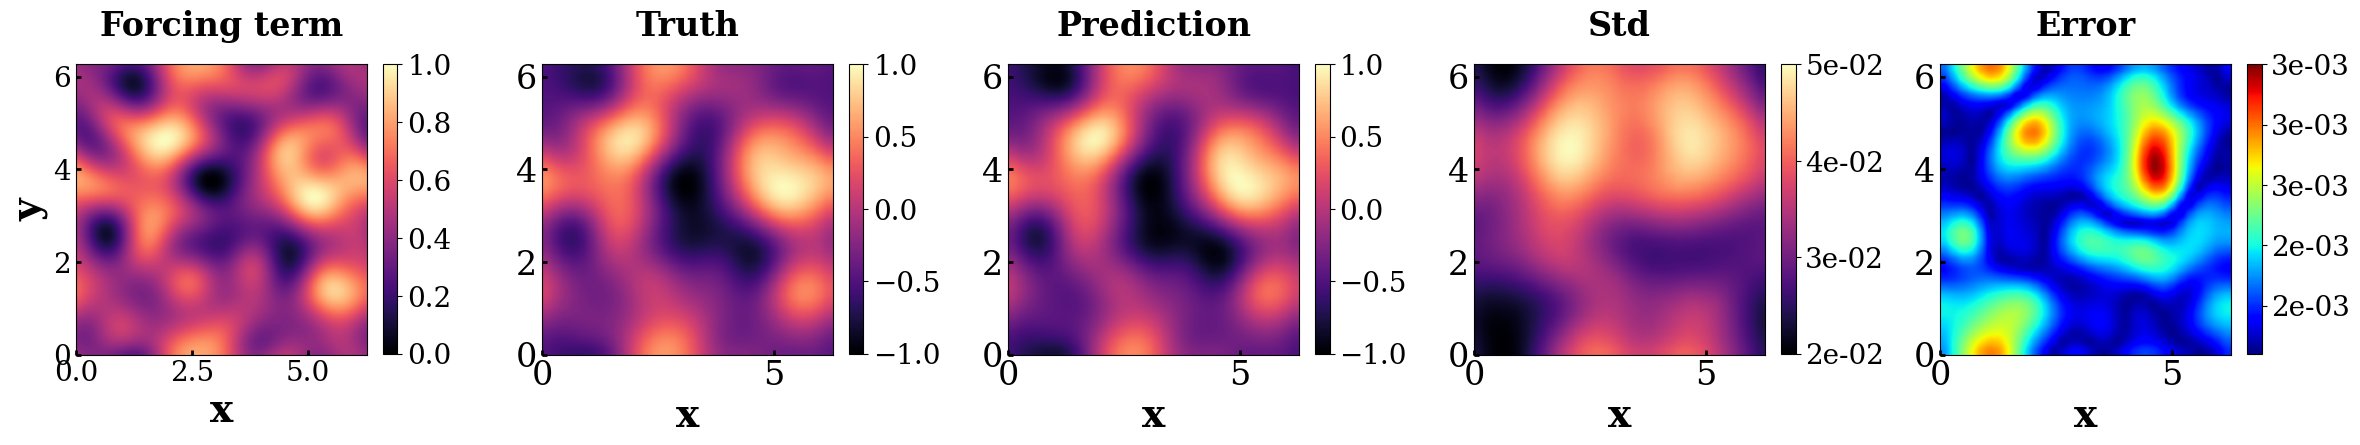

In [ ]:
# Super resolution plots

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Load the saved numpy arrays
base_dir = '/home/user/Documents/GPO/experiments/C5_navier/results/'
# current_time = 'your_saved_timestamp_here'  # Replace with the actual timestamp used when saving

mean_pred_hres = np.load(f'{base_dir}y_pred_hres_230824_1717.npy')
std_pred_hres = np.load(f'{base_dir}std_pred_hres_230824_1717.npy')
SDD_sample_pred = np.load(f'{base_dir}hres_resultsSDD_sample_predictions_130824_1044.npy')
# Assuming resl, x_test, y_t_hres, and x_axis are already defined
resl = 32  # Update this if the resolution is different

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 20

figure, axes = plt.subplots(1, 5, figsize=(24, 6))

# Assuming index is the example you want to plot
index = 0

# Initial Condition (IC)
axes[0].set_title("Forcing term", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[0].imshow(
    x_test_hres[index, :, :], 
    cmap="magma",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    origin="lower",
    interpolation="Gaussian",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[0], fraction=0.045)
axes[0].set_ylabel("y", fontweight="bold", fontsize=28)
axes[0].set_xlabel("x", fontweight="bold", fontsize=28)
axes[0].tick_params(axis='both', labelsize="medium", width=2, direction='in')

# Ground Truth
axes[1].set_title("Truth", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[1].imshow(
    y_t_hres.detach().cpu().numpy().reshape(y_t_hres.shape[0], resl, resl)[index, :, :],  # Assuming y_t_hres is correctly shaped
    origin="lower",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    cmap="magma",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[1], fraction=0.045)
axes[1].set_xlabel("x", fontweight="bold", fontsize=28)
axes[1].tick_params(axis='both', labelsize="large", width=2, direction='in')

# Model Prediction
axes[2].set_title("Prediction", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[2].imshow(
    mean_pred_hres.reshape(y_t_hres.shape[0], resl, resl)[index, :, :],  # Using loaded mean prediction
    origin="lower",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    cmap="magma",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[2], fraction=0.045)
axes[2].set_xlabel("x", fontweight="bold", fontsize=28)
axes[2].tick_params(axis='both', labelsize="large", width=2, direction='in')

# Standard Deviation
axes[3].set_title("Std", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[3].imshow(
    std_pred_hres.reshape(std_pred_hres.shape[0], resl, resl)[index, :, :],  # Using loaded variance prediction
    cmap="magma",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    origin="lower",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=0.02, vmax=0.05))
sm.set_array([])
plt.colorbar(sm, ax=axes[3], fraction=0.045, format='%.e')
axes[3].set_xlabel("x", fontweight="bold", fontsize=28)
axes[3].tick_params(axis='both', labelsize="large", width=2, direction='in')

# Prediction Error
axes[4].set_title("Error", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[4].imshow(
    np.abs(
        y_t_hres.detach().cpu().reshape(y_t.shape[0], resl, resl)[index, :, :]
        - mean_pred_hres.reshape(y_t.shape[0], resl, resl)[index, :, :]
    ),
    cmap="jet",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    origin="lower",
)
sm = ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=3e-3, vmax=2e-3))
sm.set_array([])
plt.colorbar(sm, ax=axes[4], fraction=0.045, format='%.e')
axes[4].set_xlabel("x", fontweight="bold", fontsize=28)
axes[4].tick_params(axis='both', labelsize="large", width=2, direction='in')

plt.tight_layout()
# plt.savefig('/home/user/Documents/GPO/experiments/C5_navier/civ_Row_NS_04_24_8_24.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()


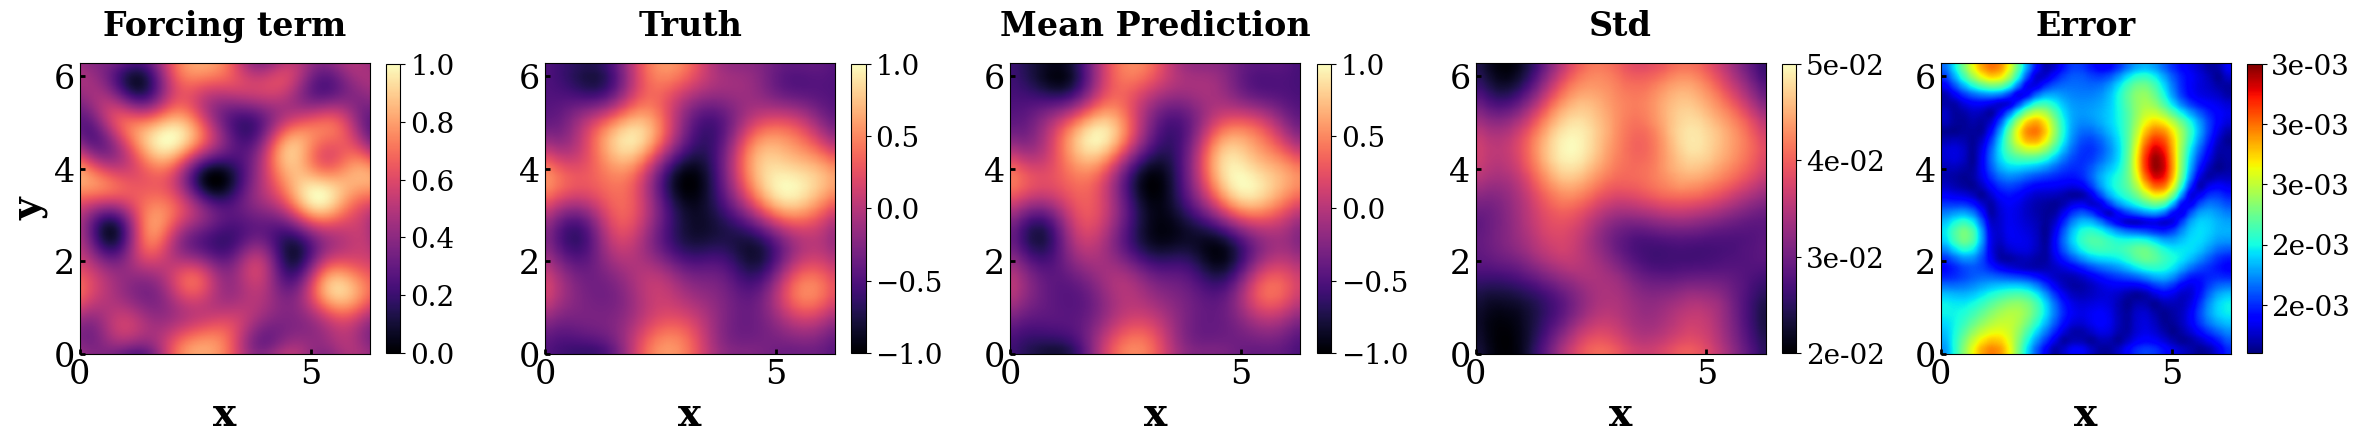

In [ ]:
# Super resolution plots

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Assuming resl, x_test_hres, y_t_hres, mean_pred_hres, std_pred_hres are already defined
resl = 32

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 20

figure, axes = plt.subplots(1, 5, figsize=(24, 6))

# Define tick parameters
common_tick_params = {
    'axis': 'both', 
    'labelsize': "large", 
    'width': 2, 
    'direction': 'in'
}

# Assuming index is the example you want to plot
index = 0

# Forcing term (IC)
axes[0].set_title("Forcing term", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[0].imshow(
    x_test_hres[index, :, :], 
    cmap="magma",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    origin="lower",
    interpolation="Gaussian",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[0], fraction=0.045)
axes[0].set_ylabel("y", fontweight="bold", fontsize=28)
axes[0].set_xlabel("x", fontweight="bold", fontsize=28)
axes[0].tick_params(**common_tick_params)

# Ground Truth
axes[1].set_title("Truth", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[1].imshow(
    y_t_hres.detach().cpu().numpy().reshape(y_t_hres.shape[0], resl, resl)[index, :, :],  
    origin="lower",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    cmap="magma",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[1], fraction=0.045)
axes[1].set_xlabel("x", fontweight="bold", fontsize=28)
axes[1].tick_params(**common_tick_params)

# Model Prediction
axes[2].set_title("Mean Prediction", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[2].imshow(
    mean_pred_hres.reshape(y_t_hres.shape[0], resl, resl)[index, :, :],  
    origin="lower",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    cmap="magma",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[2], fraction=0.045)
axes[2].set_xlabel("x", fontweight="bold", fontsize=28)
axes[2].tick_params(**common_tick_params)

# Standard Deviation
axes[3].set_title("Std", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[3].imshow(
    std_pred_hres.reshape(std_pred_hres.shape[0], resl, resl)[index, :, :],  
    cmap="magma",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    origin="lower",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=0.02, vmax=0.05))
sm.set_array([])
plt.colorbar(sm, ax=axes[3], fraction=0.045, format='%.e')
axes[3].set_xlabel("x", fontweight="bold", fontsize=28)
axes[3].tick_params(**common_tick_params)

# Prediction Error
axes[4].set_title("Error", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[4].imshow(
    np.abs(
        y_t_hres.detach().cpu().reshape(y_t.shape[0], resl, resl)[index, :, :]
        - mean_pred_hres.reshape(y_t.shape[0], resl, resl)[index, :, :]
    ),
    cmap="jet",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    origin="lower",
)
sm = ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=3e-3, vmax=2e-3))
sm.set_array([])
plt.colorbar(sm, ax=axes[4], fraction=0.045, format='%.e')
axes[4].set_xlabel("x", fontweight="bold", fontsize=28)
axes[4].tick_params(**common_tick_params)

plt.tight_layout()
plt.savefig('/home/user/Documents/GPO/experiments/C5_navier/super_Row_NS_10_09.pdf', format='pdf', dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
# Simple predictions 

# Load the saved numpy arrays
base_dir = '/home/user/Documents/GPO/experiments/C5_navier/results/'
# current_time = 'your_saved_timestamp_here'  # Replace with the actual timestamp used when saving

mean_pred = np.load(f'{base_dir}SDD_sample_mean_predictions_230824_1955.npy')
std_pred = np.load(f'{base_dir}SDD_sample_variance_predictions_230824_1955.npy')
# std_pred = np.load(f'{base_dir}SDD_sample_variance_predictions_130824_1318.npy')
# SDD_sample_pred = np.load(f'{base_dir}hres_resultsSDD_sample_predictions_130824_1044.npy')
# Assuming resl, x_test, y_t_hres, and x_axis are already defined

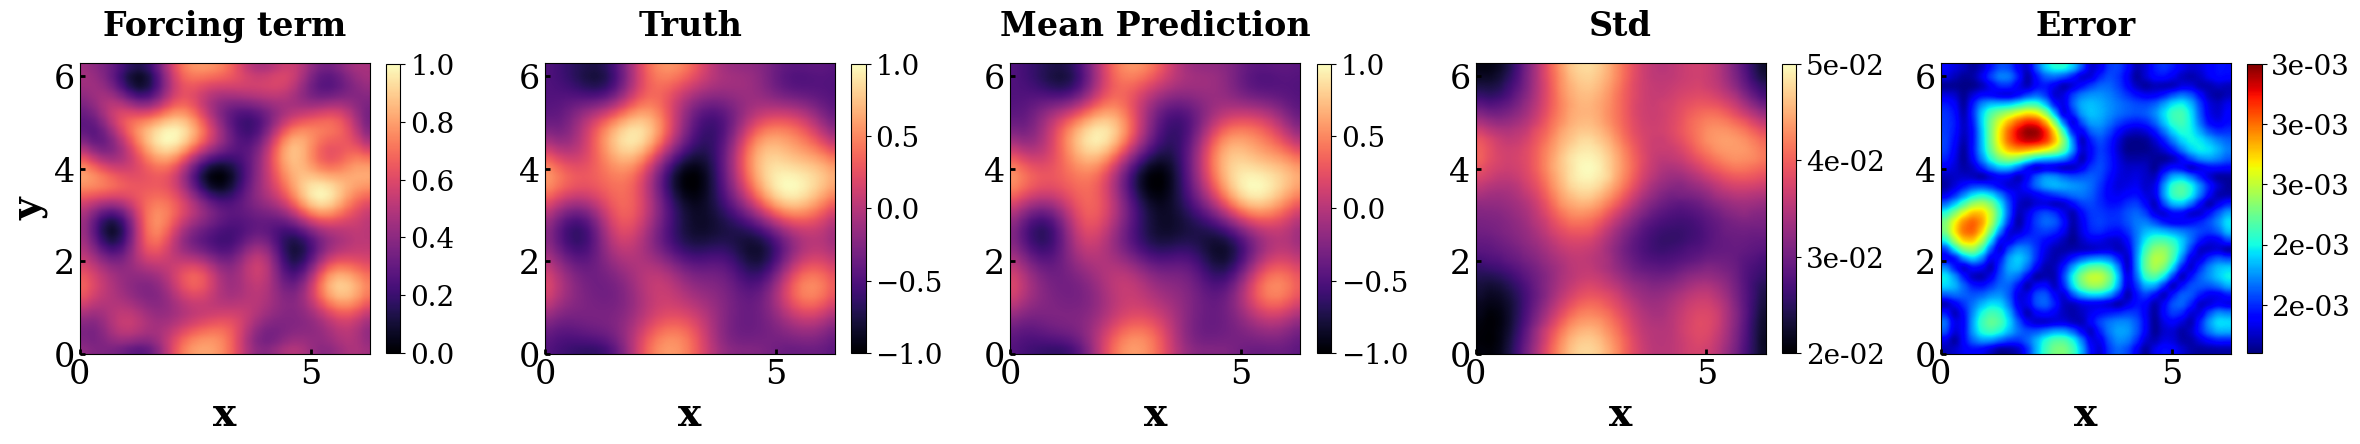

In [ ]:
# Super resolution plots

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Assuming resl, x_test, y_t, mean_pred, std_pred are already defined
resl = 32

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 20

figure, axes = plt.subplots(1, 5, figsize=(24, 6))

# Define tick parameters
common_tick_params = {
    'axis': 'both', 
    'labelsize': "large", 
    'width': 2, 
    'direction': 'in'
}

# Assuming index is the example you want to plot
index = 0

# Forcing term (IC)
axes[0].set_title("Forcing term", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[0].imshow(
    x_test[index, :, :], 
    cmap="magma",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    origin="lower",
    interpolation="Gaussian",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[0], fraction=0.045)
axes[0].set_ylabel("y", fontweight="bold", fontsize=28)
axes[0].set_xlabel("x", fontweight="bold", fontsize=28)
axes[0].tick_params(**common_tick_params)

# Ground Truth
axes[1].set_title("Truth", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[1].imshow(
    y_t.detach().cpu().numpy().reshape(y_t.shape[0], resl, resl)[index, :, :],  
    origin="lower",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    cmap="magma",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[1], fraction=0.045)
axes[1].set_xlabel("x", fontweight="bold", fontsize=28)
axes[1].tick_params(**common_tick_params)

# Model Prediction
axes[2].set_title("Mean Prediction", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[2].imshow(
    mean_pred.reshape(y_t.shape[0], resl, resl)[index, :, :],  
    origin="lower",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    cmap="magma",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[2], fraction=0.045)
axes[2].set_xlabel("x", fontweight="bold", fontsize=28)
axes[2].tick_params(**common_tick_params)

# Standard Deviation
axes[3].set_title("Std", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[3].imshow(
    std_pred.reshape(std_pred.shape[0], resl, resl)[index, :, :],  
    cmap="magma",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    origin="lower",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=0.02, vmax=0.05))
sm.set_array([])
plt.colorbar(sm, ax=axes[3], fraction=0.045, format='%.e')
axes[3].set_xlabel("x", fontweight="bold", fontsize=28)
axes[3].tick_params(**common_tick_params)

# Prediction Error
axes[4].set_title("Error", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[4].imshow(
    np.abs(
        y_t.detach().cpu().reshape(y_t.shape[0], resl, resl)[index, :, :]
        - mean_pred.reshape(y_t.shape[0], resl, resl)[index, :, :]
    ),
    cmap="jet",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    origin="lower",
)
sm = ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=3e-3, vmax=2e-3))
sm.set_array([])
plt.colorbar(sm, ax=axes[4], fraction=0.045, format='%.e')
axes[4].set_xlabel("x", fontweight="bold", fontsize=28)
axes[4].tick_params(**common_tick_params)

plt.tight_layout()
plt.savefig('/home/user/Documents/GPO/experiments/C5_navier/Row_NS_10_09.pdf',format='pdf',dpi=600,bbox_inches='tight')

plt.show()


In [ ]:
# Changes for Review

# Super resolution plots

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Assuming resl, x_test, y_t, mean_pred, std_pred are already defined
resl = 32

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 20

figure, axes = plt.subplots(1, 5, figsize=(24, 6))

# Define tick parameters
common_tick_params = {
    'axis': 'both', 
    'labelsize': "large", 
    'width': 2, 
    'direction': 'in'
}


# Assuming index is the example you want to plot
index = 0

# Forcing term (IC)
axes[0].set_title("Forcing term", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[0].imshow(
    x_test[index, :, :], 
    cmap="magma",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    origin="lower",
    interpolation="Gaussian",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[0], fraction=0.045)
axes[0].set_ylabel("y", fontweight="bold", fontsize=28)
axes[0].set_xlabel("x", fontweight="bold", fontsize=28)
axes[0].tick_params(**common_tick_params)

# Ground Truth
axes[1].set_title("Truth", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[1].imshow(
    y_t.detach().cpu().numpy().reshape(y_t.shape[0], resl, resl)[index, :, :],  
    origin="lower",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    cmap="magma",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[1], fraction=0.045)
axes[1].set_xlabel("x", fontweight="bold", fontsize=28)
axes[1].tick_params(**common_tick_params)

# Model Prediction
axes[2].set_title("Mean Prediction", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[2].imshow(
    mean_pred.reshape(y_t.shape[0], resl, resl)[index, :, :],  
    origin="lower",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    cmap="magma",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[2], fraction=0.045)
axes[2].set_xlabel("x", fontweight="bold", fontsize=28)
axes[2].tick_params(**common_tick_params)

# Standard Deviation
axes[3].set_title("Std", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[3].imshow(
    std_pred.reshape(std_pred.shape[0], resl, resl)[index, :, :],  
    cmap="magma",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    origin="lower",
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=0.02, vmax=0.05))
sm.set_array([])
plt.colorbar(sm, ax=axes[3], fraction=0.045, format='%.e')
axes[3].set_xlabel("x", fontweight="bold", fontsize=28)
axes[3].tick_params(**common_tick_params)

axes[4].set_title("Relative Error", color="black", fontsize=24, fontweight="bold", pad=20)
# Extract the prediction and ground truth, converting to NumPy arrays
y_true = y_t.detach().cpu().numpy().reshape(y_t.shape[0], resl, resl)[index, :, :]
y_pred = mean_pred.reshape(y_t.shape[0], resl, resl)[index, :, :]

# Add a small epsilon to avoid division by zero
epsilon = 1e-8

# Compute the per-pixel relative errors
# relative_error = np.abs(y_pred - y_true) / (np.abs(y_true) + epsilon)
y_t_np = y_t.detach().cpu().numpy()  # Convert y_t to NumPy

# Reshape the y_t array to the correct shape (assuming resl is defined)
y_t_reshaped = y_t_np.reshape(y_t.shape[0], resl, resl)

# Compute the norms and relative error
relative_error = np.mean(
    np.linalg.norm(mean_pred - y_t_np, axis=1) /
    np.linalg.norm(y_t_reshaped[index, :, :], axis=1)
)

# Plot the relative error
image = axes[4].imshow(
    relative_error,
    cmap="jet",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
    interpolation="Gaussian",
    origin="lower",
)

sm = ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=3e-2, vmax=2e-1))
sm.set_array([])
plt.colorbar(sm, ax=axes[4], fraction=0.045, format='%.e')
axes[4].set_xlabel("x", fontweight="bold", fontsize=28)
axes[4].tick_params(**common_tick_params)

plt.tight_layout()
# plt.savefig('/home/user/Documents/WaKeGP/experiments/C5_navier/Row_NS_10_09.pdf',format='pdf',dpi=600,bbox_inches='tight')

plt.show()



In [ ]:
y_t.shape, mean_pred.shape

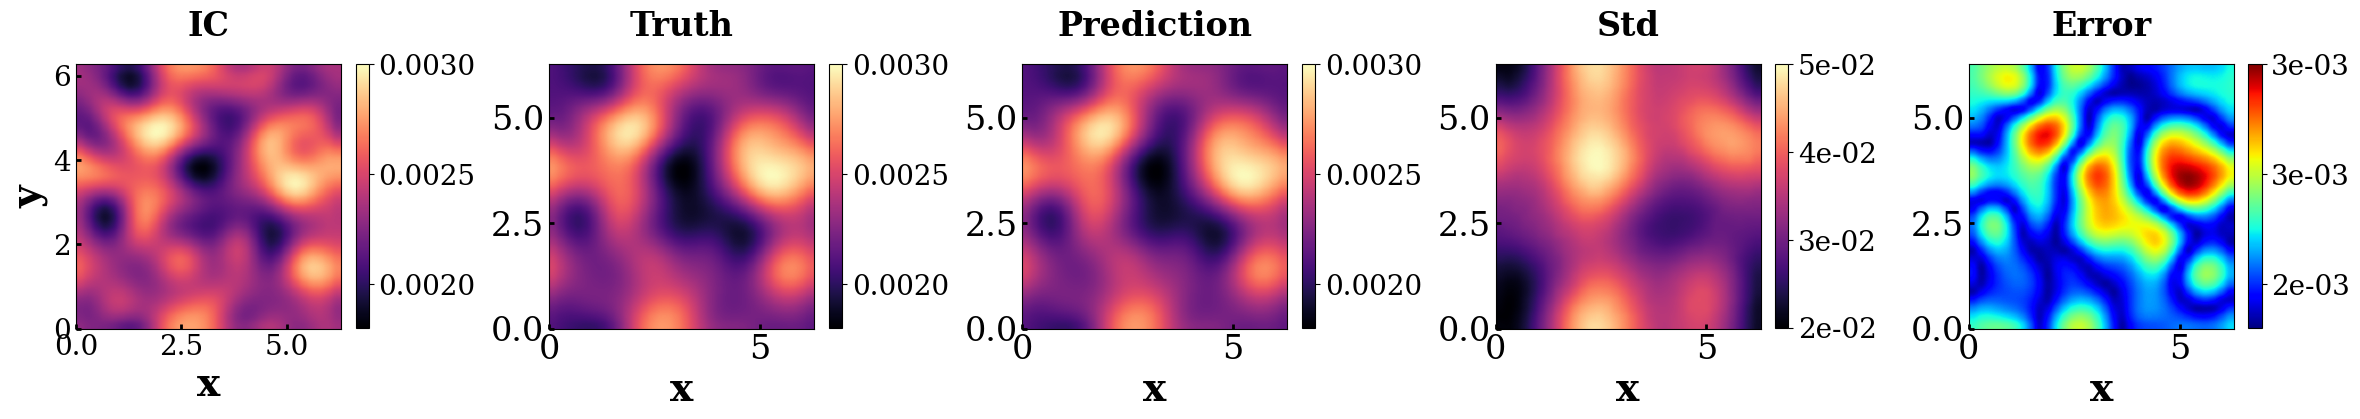

In [ ]:
from matplotlib.cm import ScalarMappable
       
resl = 32

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 20

figure, axes = plt.subplots(1, 5, figsize=(24, 6))

# Assuming index is the example you want to plot
index = 0

# BC
axes[0].set_title("Forcing term", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[0].imshow(
    x_test[index, :, :, 0],
    cmap="magma",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    origin="lower",
    interpolation="Gaussian",
)
# sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[0], fraction=0.045)
axes[0].set_ylabel("y", fontweight="bold", fontsize=28)
axes[0].set_xlabel("x", fontweight="bold", fontsize=28)
axes[0].tick_params(axis='both', labelsize="medium", width=2, direction='in')
# for label in axes[0].get_xticklabels() + axes[0].get_yticklabels():
#     label.set_fontweight('bold')
# True
axes[1].set_title("Truth", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[1].imshow(
    y_t.detach().cpu().numpy().reshape(y_t.shape[0], resl, resl)[index, :, :],
    origin="lower",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    cmap="magma",
    # vmin=-1,
    # vmax=1,
)
# sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[1], fraction=0.045)
axes[1].set_xlabel("x", fontweight="bold", fontsize=28)
axes[1].tick_params(axis='both', labelsize="large", width=2, direction='in')
# for label in axes[1].get_xticklabels() + axes[1].get_yticklabels():
#     label.set_fontweight('bold')

# Predictions
axes[2].set_title("Prediction", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[2].imshow(
    y_pred_sdd.reshape(y_pred_sdd.shape[0], resl, resl)[index, :, :],
    origin="lower",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    cmap="magma",
    # vmin=-1,
    # vmax=1,
)
# sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, ax=axes[2], fraction=0.045)
axes[2].set_xlabel("x", fontweight="bold", fontsize=28)
axes[2].tick_params(axis='both', labelsize="large", width=2, direction='in')
# for label in axes[2].get_xticklabels() + axes[2].get_yticklabels():
#     label.set_fontweight('bold')

# Std
axes[3].set_title("Std", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[3].imshow(
    var_pred_sdd.reshape(var_pred_sdd.shape[0], resl, resl)[index, :, :],
    cmap="magma",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    origin="lower",
    # vmin=0.4,
    # vmax=0.9,
)
sm = ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=0.02, vmax=0.05))
sm.set_array([])
plt.colorbar(sm, ax=axes[3], fraction=0.045, format='%.e')
# axes[3].set_ylabel("y", fontweight="bold", fontsize=24)
axes[3].set_xlabel("x", fontweight="bold", fontsize=28)
axes[3].tick_params(axis='both', labelsize="large", width=2, direction='in')
# for label in axes[3].get_xticklabels() + axes[3].get_yticklabels():
#     label.set_fontweight('bold')

# Error
axes[4].set_title("Error", color="black", fontsize=24, fontweight="bold", pad=20)
image = axes[4].imshow(
    np.abs(
        y_t_hres.detach().cpu().numpy().reshape(y_t.shape[0], resl, resl)[index, :, :]
        - y_pred_sdd.reshape(y_pred_sdd.shape[0], resl, resl)[index, :, :]
    ),
    cmap="jet",
    extent=[0, 2*np.pi, 0, 2*np.pi],
    interpolation="Gaussian",
    origin="lower",
    # vmax=2e-2,
    # vmin=3e-4,
)
sm = ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=3e-3, vmax=2e-3))
sm.set_array([])
plt.colorbar(sm, ax=axes[4], fraction=0.045, format='%.e')
axes[4].set_xlabel("x", fontweight="bold", fontsize=28)
axes[4].tick_params(axis='both', labelsize="large", width=2, direction='in')
# for label in axes[4].get_xticklabels() + axes[4].get_yticklabels():
#     label.set_fontweight('bold')

plt.tight_layout()
# plt.savefig('/home/user/Documents/GPO/experiments/C5_navier/Row_NS_01_13_8_24.pdf',format='pdf',dpi=600,bbox_inches='tight')
